In [1]:
import os
import pyro
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pyro.distributions as dist

from torch import Tensor
from tqdm.auto import trange
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
from pyro.distributions import constraints
from pyro.infer.autoguide import AutoDiagonalNormal

os.chdir("../../")

from src.dgp_rff.outer_layer import SingleGP, SingleCauchyGP

In [2]:
import torch
torch.cuda.is_available()
# trouble shoot see this link:https://stackoverflow.com/questions/77068908/how-to-install-pytorch-with-cuda-support-on-windows-11-cuda-12-no-matching

True

In [3]:
torch.cuda.current_device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
# cuda = torch.device('cuda') 

In [4]:
var1= torch.FloatTensor([1.0,2.0,3.0]).cuda()

In [5]:
var1.device

device(type='cuda', index=0)

In [6]:
torch.cuda.memory_allocated()

512

  # Next step

0. Get familiar with the coding structure
1. CPU -> GPU
2. Last step without bias
3. Figure out how they train
4. How to access the posterior mean and std/scale from the model
5. Learn pickle: numpy.ndarray, png
6. ....
7. construct a DeepGP class

In [7]:
# Set random seed for reproducibility
np.random.seed(42)

# Read data
cwd = os.getcwd()
print(cwd)

X_train_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_X_train.txt")
X_test_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_X_test.txt")
Y_train_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_Y_train.txt")
Y_test_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_Y_test.txt")

x_obs = np.loadtxt(X_train_path)
y_obs = np.loadtxt(Y_train_path)
x_val = np.loadtxt(X_test_path)
y_val = np.loadtxt(Y_test_path)

# Set plot limits and labels
xlims = [-0.2, 0.2]

# The X and Y have to be at least 2-dim
x_train = torch.from_numpy(x_obs).float().reshape(-1,1)
y_train = torch.from_numpy(y_obs).float()
x_test = torch.from_numpy(x_val).float().reshape(-1,1)
y_test = torch.from_numpy(y_val).float()

C:\Users\yuanq\OneDrive\Desktopold\SB\research\DGPII\program\DGP-RFF-main


In [8]:
train_indices = np.linspace(0,9000,10,dtype = int)
test_indices = np.linspace(0,90,10,dtype = int)
new_x_train = x_train[train_indices]
new_y_train = y_train[train_indices]
new_x_test = x_test[test_indices]
new_y_test = y_test[test_indices]

In [9]:
new_x_train = new_x_train.cuda()
new_y_train = new_y_train.cuda()
new_x_test = new_x_test.cuda()
new_y_test = new_y_test.cuda()
new_x_train.shape

torch.Size([10, 1])

In [10]:
x_train = x_train.cuda()


In [11]:
y_train = y_train.cuda()
x_test = x_test.cuda()
y_test = y_test.cuda()

In [12]:
x_train.device

device(type='cuda', index=0)

In [13]:


  # X = [
#     [1,2,3],
#     [4,5,6,7,8]
#     ]
# X_path = os.path.join(cwd, "folds", "test.pickle")
# with open(X_path, 'wb') as f:
#     pickle.dump(X, f)

In [14]:
# with open(X_path, 'rb') as f:
#     X_read = pickle.load(f)

In [15]:
class Model(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, J=50):
        super().__init__()
        
        self.out_dim = out_dim
        self.model = SingleGP(in_dim, out_dim, J)
        self.model.to('cuda')

    def forward(self, x, y=None):
        mu = self.model(x).squeeze() #10000*6
        
        # batch shape | event shapt
        # 10000       |
        
        scale = pyro.sample("sigma", dist.Gamma(torch.tensor(0.5, device='cuda'), torch.tensor(1.0, device='cuda'))).expand(self.out_dim)  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]): # x.shape[0]=10000
            # obs = xxx("obs", mu, obs=y)
            obs = pyro.sample("obs", dist.MultivariateNormal(mu.cuda(), torch.diag(scale * scale).cuda()), obs=y)
            
#         f1: phi(Omega x)W (+ epsilon1)
#         f2: phi(Omega f1)W (+ epsilon2)
        
#         f2 + epsilon ~ N(0, Sigma)
            
        return mu

In [31]:
model = Model(in_dim=x_train.shape[1], out_dim=y_train.shape[1], J=50)
model = model.to('cuda')

In [32]:
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 15000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(new_x_train, new_y_train)
    progress_bar.set_postfix(loss=f"{loss / new_x_train.shape[0]:.3f}")

  0%|          | 0/15000 [00:00<?, ?it/s]

In [33]:
model.parameters()

<generator object Module.parameters at 0x000001B5AC4498C0>

In [34]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(new_x_test)

In [35]:
y_pred = preds['obs'].cpu().detach().numpy().mean(axis=0)

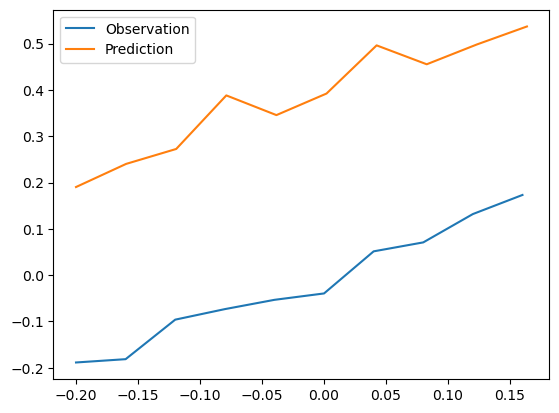

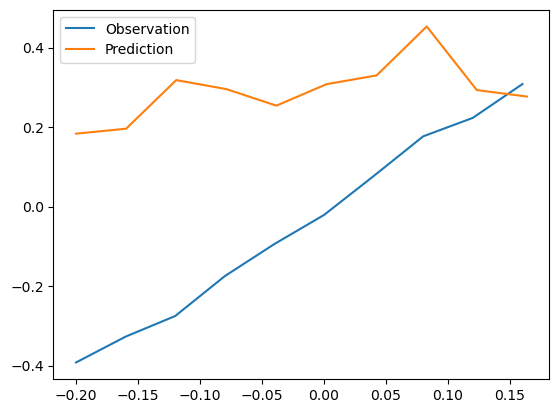

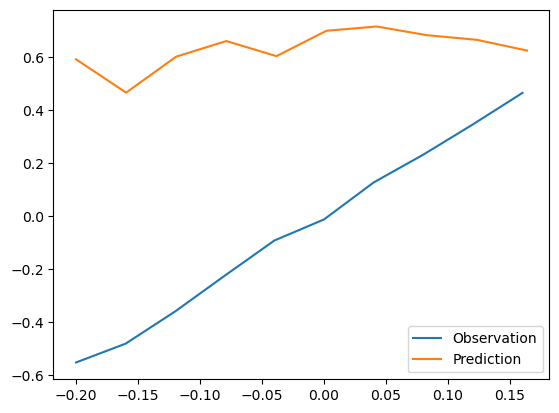

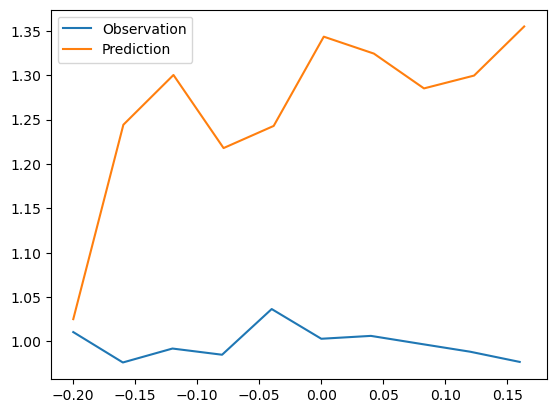

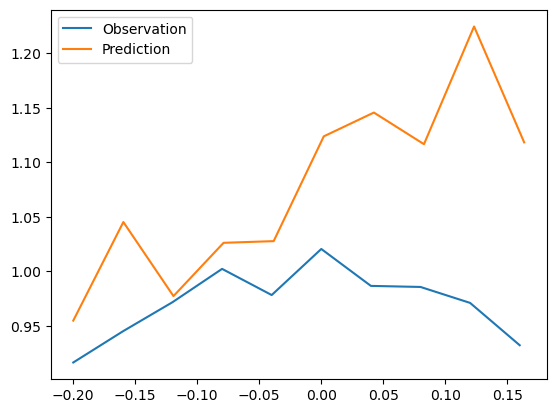

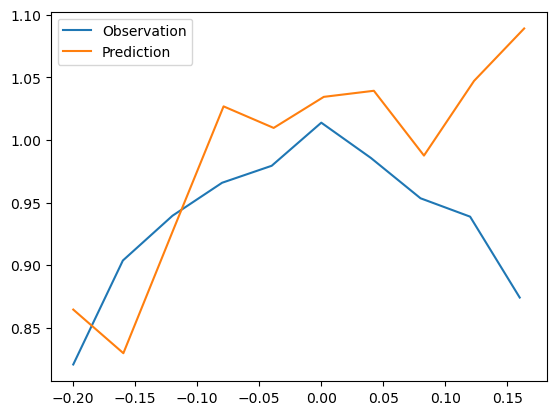

In [36]:
for d in range(6):
    plt.plot(new_x_train.cpu(), new_y_train.cpu()[:,d], label="Observation")
    plt.plot(new_x_test.cpu(), y_pred[:,d], label="Prediction")
    plt.legend()
    plt.show()

In [ ]:
# sampled Omega: model.model.layers[0].layer.weight

In [ ]:
# preds['model.layers.0.layer.weight'].squeeze().mean(axis=0): Omega estimator

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

In [ ]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.nn import PyroModule, PyroSample

# 定义两层BNN模型
class BayesianNN(PyroModule):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # 第一层权重和偏置
        self.fc1 = PyroModule[nn.Linear](input_size, hidden_size)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_size, input_size]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([hidden_size]).to_event(1))

        # 第二层权重和偏置
        self.fc2 = PyroModule[nn.Linear](hidden_size, output_size)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([output_size, hidden_size]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([output_size]).to_event(1))

    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        mean = self.fc2(x)
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

# 生成一些合成数据
input_size = 6
hidden_size = 10
output_size = 1
N = 100  # 样本数

# 真实参数
true_w1 = torch.randn(hidden_size, input_size)
true_b1 = torch.randn(hidden_size)
true_w2 = torch.randn(output_size, hidden_size)
true_b2 = torch.randn(output_size)

# 生成数据
x_data = torch.randn(N, input_size)
y_data = torch.relu(x_data @ true_w1.t() + true_b1) @ true_w2.t() + true_b2 + 0.1 * torch.randn(N, output_size)

# 初始权重
init_weight = torch.tensor([0.4, 0.2, 0.3, -0.4, 0.3, 0.2]).reshape(10, input_size)  # 修改为与hidden_size匹配

# 定义引导函数
def guide(x, y=None):
    guide = BayesianNN(input_size, hidden_size, output_size)
    guide.fc1.weight = PyroSample(dist.Normal(pyro.param("w1_loc", init_weight),
                                              pyro.param("w1_scale", torch.ones([hidden_size, input_size]), constraint=dist.constraints.positive)).to_event(2))
    guide.fc1.bias = PyroSample(dist.Normal(pyro.param("b1_loc", torch.randn(hidden_size)),
                                            pyro.param("b1_scale", torch.ones(hidden_size), constraint=dist.constraints.positive)).to_event(1))
    guide.fc2.weight = PyroSample(dist.Normal(pyro.param("w2_loc", torch.randn(output_size, hidden_size)),
                                              pyro.param("w2_scale", torch.ones(output_size, hidden_size), constraint=dist.constraints.positive)).to_event(2))
    guide.fc2.bias = PyroSample(dist.Normal(pyro.param("b2_loc", torch.randn(output_size)),
                                            pyro.param("b2_scale", torch.ones(output_size), constraint=dist.constraints.positive)).to_event(1))
    return guide

# 优化器和损失函数
optimizer = Adam({"lr": 0.01})
svi = SVI(BayesianNN(input_size, hidden_size, output_size), guide, optimizer, loss=Trace_ELBO())

# 训练
num_iterations = 1000
for i in range(num_iterations):
    loss = svi.step(x_data, y_data)
    if i % 100 == 0:
        print(f"Step {i} : loss = {loss}")

# 打印估计的参数键和值
for name, value in pyro.get_param_store().items():
    print(f"{name} : {value.detach().numpy()}")


1 -> 50; 100 -> 6

Omega 1*50  1*50
W     6*100 6*100
bias  6     6
sigma 1     1

In [ ]:
# def model(data):
#   alpha = torch.tensor(6.0)
#   beta = torch.tensor(10.0)
#   pay_probs = pyro.sample('pay_probs', dist.Beta(alpha, beta).expand(3).independent(1))
#   normalized_pay_probs = pay_probs / torch.sum(pay_probs)

#   with pyro.iarange('data_loop', len(data)):
#     pyro.sample('obs', dist.Categorical(probs=normalized_pay_probs), obs=data)

In [ ]:
# def guide(data):
#   alphas = pyro.param('alphas', torch.tensor(6.).expand(3), constraint=constraints.positive)
#   betas = pyro.param('betas', torch.tensor(10.).expand(3), constraint=constraints.positive) 

#   pyro.sample('pay_probs', dist.Beta(alphas, betas).independent(1))